In [104]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack
try:
    from astropy.cosmology import Planck18_arXiv_v2
    cosmo = Planck18_arXiv_v2
except ImportError as e:
    from astropy.cosmology import Planck15
    cosmo = Planck15

import logging
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_gwmap

from desitarget import io, cuts

In [151]:
def get_sweepfiles(sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0', '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']):
    """Given a search folder or folders, return a list of sweep files.
    
    For details on file locations see For details see http://legacysurvey.org/dr8/files/.
    
    Parameters
    ----------
    sweepfolders : str or list
        A folder or list of folders to search for sweep files.
    
    Returns
    -------
    sweeplist : list
        List of sweep files.
    """
    sweeplist = None
    
    if np.isscalar(sweepfolders):
        sweeplist = io.list_sweepfiles(sweepfolders)
    else:
        for fldr in sweepfolders:
            if sweeplist is None:
                sweeplist = io.list_sweepfiles(fldr)
            else:
                sweeplist += io.list_sweepfiles(fldr)
                
    return sweeplist

def get_objects_in_gw_contour(sweepfolders, lvc_hp_file, level=0.9):
    # Get luminosity distance to GW.
    # Read metadata.
    hdus = fits.open(lvc_hp_file)
    header = hdus[1].header
    distmean = header['DISTMEAN']
    diststd = header['DISTSTD']
    
    # Get contours for the GW skymap.
    gwmap = hp.read_map(lvc_hp_file)
    gw_maxprob = np.max(gwmap)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)
    thresh = compute_quantiles([level], gwmap)[0]
    logging.info('{:g}% confidence level of GW map {:s} = {:g}'.format(100*level, lvc_hp_file, thresh))
    
    # Get list of pixels above threshold defined by level.
    pixels = hp.ring2nest(nside, np.arange(npix))
    pixids = pixels[gwmap > thresh]
    
    # Loop through all sweeps, see if pixel indices match with any bricks.
    sweepfiles = get_sweepfiles(sweepfolders)
    gwsweeps = []
    for sf in sweepfiles:
        ramin, ramax, decmin, decmax = io.decode_sweep_name(sf)
        ra = [ramin, ramax, ramax, ramin]
        dec = [decmin, decmin, decmax, decmax]
        box = hp.ang2vec(ra, dec, lonlat=True)
        boxpix = hp.query_polygon(nside, box, nest=True)
        
        if not set(boxpix).isdisjoint(pixids):
            gwsweeps.append(sf)

    # Grab photo-z data and read everything into a table.
    gwspeeps, photozs = get_sweep_photo_z(gwsweeps)
    
    objtab = None
    for sf, pz in zip(gwsweeps, photozs):
        print(sf)
        data = Table(io.read_tractor(sf, columns=['BRICKID', 'BRICKNAME', 'OBJID', 'RA', 'DEC']))
        data_pz = Table.read(pz)
        
        # Cut pixels not in 
        brickpix = hp.ang2pix(nside, data['RA'], data['DEC'], lonlat=True, nest=True)
        gw_prob = gwmap[hp.nest2ring(nside, brickpix)] / gw_maxprob
        data.add_column(Column(name='Pr_radec', data=gw_prob))
        
        in_gw = np.isin(brickpix, pixids)
        valid_z = data_pz['z_phot_mean'] >= 0
        select = np.logical_and(in_gw, valid_z)
        
        if objtab is None:
            objtab = hstack([data[select], data_pz[select]])
        else:
            objtab = vstack([objtab, hstack([data[select], data_pz[select]])])
            
    # Compute luminosity distance given mean photo-z.
    nonzero_prob = objtab['Pr_radec'] > 0
    logging.info('Computing luminosity distances for {:d} objects.'.format(np.sum(nonzero_prob)))
    
    d_L = np.zeros(len(objtab))
    d_L[nonzero_prob] = cosmo.luminosity_distance(objtab[nonzero_prob]['z_phot_mean']).to('Mpc').value
    objtab.add_column(Column(name='D_L', data=d_L))
    
    # Compute distance probability relative to max.
    pr_d_L = np.zeros(len(objtab))
    pr_d_L[nonzero_prob] = np.exp(-0.5*((d_L - distmean)/diststd)**2)
    objtab.add_column(Column(name='Pr_D_L', data=pr_d_L))

    return objtab
    
def get_sweep_photo_z(sweepfiles):
    # Search for matching photo-z files.
    sweeplist = sweepfiles
    photozlist = None
    logging.warning('Photo-z search hardcoded for DR8 v8.0.')

    for sweep in sweeplist:
        sweep_pz = sweep.replace('8.0', '8.0-photo-z').replace('.fits', '-pz.fits')

        # If photo-z file not found, remove corresponding sweep file from list.
        if os.path.exists(sweep_pz):
            if photozlist is None:
                photozlist = [sweep_pz]
            else:
                photozlist.append(sweep_pz)
        else:
            sweeplist.remove(sweep)
            
    return sweeplist, photozlist

In [152]:
sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0',
              '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']
gwfile = 'S200224ca_LALInference.fits.gz'

test = get_objects_in_gw_contour(sweepfolders, gwfile)
# sweepfiles = get_sweepfiles()
# sweeps, photozs = get_sweep_photo_z(sweepfiles)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-160p010-170p015.fits


In [153]:
test

BRICKID,BRICKNAME,OBJID,RA,DEC,Pr_radec,z_phot_mean,z_phot_median,z_phot_std,z_phot_l68,z_phot_u68,z_phot_l95,z_phot_u95,z_spec,survey,training,D_L,Pr_D_L
int32,bytes8,int32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,str10,bool,float64,float64
391213,1638p105,13,163.91044829909848,10.375358494095341,0.027714476866631654,0.5342261,0.5426291,0.08195053,0.470757,0.59792954,0.32785872,0.6688287,-99.0,,False,3159.605965711192,7.682030029040935e-06
391213,1638p105,15,163.91079213423245,10.376251016827908,0.027714476866631654,1.1720649,1.150069,0.16198546,1.0282513,1.3064152,0.95441574,1.5760465,-99.0,,False,8261.149345679836,8.446034394236358e-88
391213,1638p105,18,163.824445479138,10.379335311153516,0.027714476866631654,0.7397979,0.73783517,0.06575013,0.6745122,0.79668057,0.64354104,0.8707141,-99.0,,False,4690.056534930087,6.225182857580001e-20
391213,1638p105,19,163.8278916127404,10.38003918016361,0.027714476866631654,0.96629965,0.96591806,0.11836857,0.8515245,1.0735929,0.7441341,1.211403,-99.0,,False,6510.843596431635,2.046866078278346e-48
391213,1638p105,20,163.8271506358486,10.378847153776396,0.027714476866631654,0.53313255,0.5362221,0.17684649,0.3468765,0.6823131,0.21882549,0.9465533,-99.0,,False,3151.8321864806658,8.591853683477629e-06
391213,1638p105,21,163.82355191123185,10.376452451237274,0.027714476866631654,0.8876859,0.8857769,0.118527584,0.7818576,0.9916952,0.66354215,1.1137693,-99.0,,False,5864.999700207231,7.43896847705918e-37
391213,1638p105,22,163.82640983831237,10.380654901883746,0.027714476866631654,0.8180383,0.80971324,0.15604389,0.7015501,0.96458286,0.45561847,1.1107563,-99.0,,False,5304.785685534144,3.995911821162359e-28
391213,1638p105,24,163.82575419441739,10.376367928987372,0.027714476866631654,1.0080067,0.9968767,0.13941793,0.8890845,1.1234735,0.74404746,1.3003805,-99.0,,False,6858.910883840779,2.6085500371537314e-55
391213,1638p105,25,163.82621475839582,10.379526560972241,0.027714476866631654,1.1787049,1.1716869,0.14234334,1.0441034,1.3074011,0.94922066,1.5421838,-99.0,,False,8318.936355504753,2.6650253633606806e-89


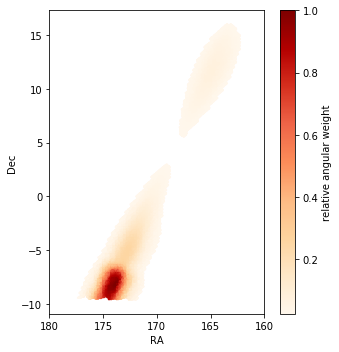

In [154]:
fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)
sc = ax.scatter(test['RA'][::100], test['DEC'][::100], s=1, c=test['Pr_radec'][::100], cmap='OrRd')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('relative angular weight')
ax.set(xlim=(180,160), xlabel='RA', ylabel='Dec', aspect='equal');

(array([36527., 27850., 22629., 19430., 17275., 15773., 15221., 14801.,
        14834., 14840., 14875., 15127., 15420., 16198., 17882., 20137.,
        25196., 59036.,     0.,     0.]),
 array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
        0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ]),
 <a list of 20 Patch objects>)

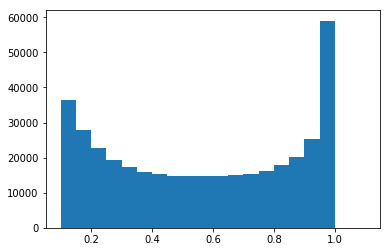

In [159]:
plt.hist(test['Pr_D_L'], bins=np.linspace(0.1,1.1,21))

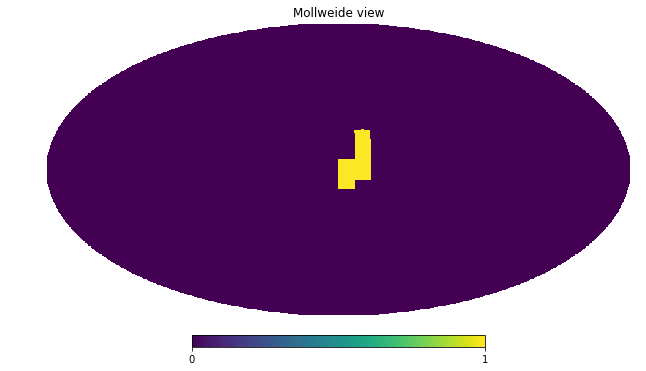

In [67]:
hp.mollview(test, flip='astro', rot=180, nest=True)